<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1">Imports</a></span></li><li><span><a href="#Define-parameters" data-toc-modified-id="Define-parameters-2">Define parameters</a></span></li><li><span><a href="#Train-models" data-toc-modified-id="Train-models-3">Train models</a></span></li><li><span><a href="#Plot-feature-importance" data-toc-modified-id="Plot-feature-importance-4">Plot feature importance</a></span></li><li><span><a href="#Plot-reliability-diagram" data-toc-modified-id="Plot-reliability-diagram-5">Plot reliability diagram</a></span></li></ul></div>

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import datetime
import os.path
import random
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree, ensemble
from sklearn.ensemble import RandomForestClassifier
import pickle
import scipy
from sklearn import calibration
import sklearn.model_selection as model_selection
import utils.bookdroputils as bd

# Define parameters

In [2]:
# Choose filenames for the models
model_filenames = ['RFmodel1.sav', 'RFmodel2.sav']
# Decide whether to save the trained model
save_models = True

# Find directory for the dataset
mydir = os.path.join('data','paperbacks')
# Collect list of files in the dataset
file_list = [f for f in os.listdir(mydir) if os.path.isfile(os.path.join(mydir, f))]

# Number of timepoints to search ahead for a price drop
futures = [60, 120]
# Fraction of the price considered a 'drop'
# E.g., 0.1 for a 10% price drop
drop_frac = .1

# Train models

In [3]:
for idx, model_filename in enumerate(model_filenames):
    # Initialize storage for features and labels
    X = list([])
    Y = list([])

    future = futures[idx]

    # get data from files
    for product_id in file_list:
        # Read file
        df = pd.read_csv(os.path.join(mydir, product_id))
        # Drop missing values
        df.dropna(inplace=True)
        # Convert prices to array
        prices = np.array(df['price'])

        # collect data at intervals
        for k in range(
                random.randint(0, 30) + 120 + 5, df.shape[0] - future - 30,
                60):

            # Extract and store price features
            features = bd.compute_features(prices[:k + 1], drop_frac)
            X.append(features)

            # Store the class label
            if np.any(prices[(k + 1):(k + future + 1)] < (1 - drop_frac) *
                      prices[k]):
                Y.append(1)
            else:
                Y.append(0)

    # Convert features and labels to arrays
    x_train = np.array(X)
    y_train = np.array(Y)

    # Hold out some training data to calibrate the classifier
    x_cal, x_train, y_cal, y_train = model_selection.train_test_split(
        x_train, y_train, train_size=0.15, test_size=0.85)

    # Balance classes in training set
    undersample = RandomUnderSampler(sampling_strategy='majority')
    x_train_balanced, y_train_balanced = undersample.fit_resample(
        x_train, y_train)

    # Define parameters for the random forest model
    parameters = {
        'bootstrap': True,
        'max_depth': 10,
        'max_features': 'sqrt',
        'min_samples_leaf': 4,
        'min_samples_split': 4,
        'n_estimators': 300
    }
    # Initialize the model
    RF_model_uncalibrated = RandomForestClassifier(**parameters)
    # Fit the model
    RF_model_uncalibrated.fit(x_train_balanced, y_train_balanced)
    # Predict probabilities on the training set
    uncalibrated_probs = RF_model_uncalibrated.predict_proba(x_train)

    # Model calibration
    # Create calibrated model
    RF_model = calibration.CalibratedClassifierCV(RF_model_uncalibrated,
                                                  cv="prefit",
                                                  method='sigmoid')
    # Fit the model
    RF_model.fit(x_cal, y_cal)
    calibrated_probs = RF_model.predict_proba(x_train)
    # Find the classification threshold that gives the same
    # outputs as the calibrated classifier
    threshold = np.quantile(
        calibrated_probs[:, 1],
        np.sum(uncalibrated_probs[:, 1] <= .5) /
        np.size(uncalibrated_probs[:, 1]))

    # You'll need this threshold when using the model to make preductions
    print('Threshold for ' + model_filename + ' is:')
    print(threshold)

    if save_models:
        pickle.dump(RF_model, open(model_filename, 'wb'))

Threshold for RFmodel1.sav is:
0.14295234784705693
Threshold for RFmodel2.sav is:
0.2304682764094403


# Plot feature importance

See the [slides](http://slides.book-drop.site/) (specifically slide 11) for an explanation of the features.

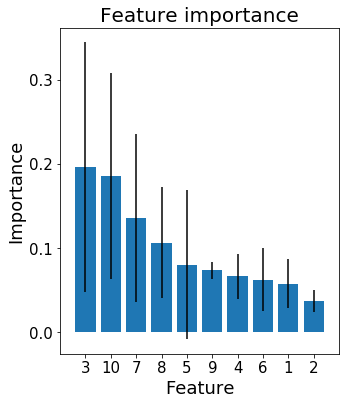

In [4]:
# Get feature importances
importances = RF_model_uncalibrated.feature_importances_
# Get error bars
std = np.std([tree.feature_importances_ for tree in RF_model_uncalibrated.estimators_],
             axis=0)
# Sort the features
indices = np.argsort(importances)[::-1]


# Plot the impurity-based feature importances of the forest
fig = plt.figure(figsize=(5,6))
ax1 = fig.add_subplot(111)
ax1.bar(range(x_train_balanced.shape[1]), importances[indices],
        yerr=std[indices], align="center")
plt.title("Feature importance",fontsize=20)
plt.xticks(range(x_train_balanced.shape[1]), indices+1,fontsize=15)
plt.xlim([-1, x_train_balanced.shape[1]])
plt.ylabel("Importance",fontsize=18)
plt.yticks([0,.1,.2,.3],fontsize=15)
plt.xlabel("Feature",fontsize=18)

plt.show()

# Plot reliability diagram

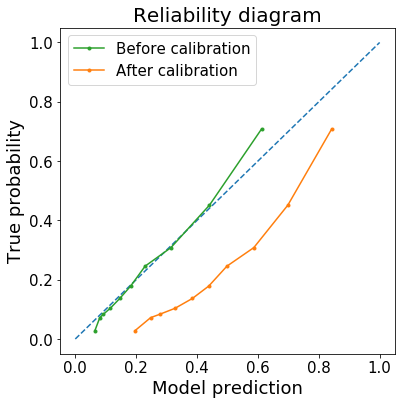

In [5]:
fig = plt.figure(figsize=(6, 6))
# Predict probabilities using uncalibrated model
probs = RF_model_uncalibrated.predict_proba(x_train)[:, 1]
# Generate data for reliability diagram
prob_true, prob_pred = calibration.calibration_curve(y_train,
                                                     probs,
                                                     n_bins=10,
                                                     strategy="quantile")
# Plot what a perfectly calibrated model would look like
plt.plot([0, 1], [0, 1], linestyle='--')
# Plot uncalibrated model reliability
b, = plt.plot(prob_pred, prob_true, marker='.')

# Predict probabilities using calibrated model
probs = RF_model.predict_proba(x_train)[:, 1]
# Generate reliability data
prob_true_calibrated, prob_pred_calibrated = calibration.calibration_curve(
    y_train, probs, n_bins=10, strategy="quantile")
# Plot calibrated model reliability
a, = plt.plot(prob_pred_calibrated, prob_true_calibrated, marker='.')

plt.title("Reliability diagram", fontsize=20)
plt.ylabel("True probability", fontsize=18)
plt.yticks(np.arange(0, 1.2, .2), fontsize=15)
plt.xlabel("Model prediction", fontsize=18)
plt.xticks(np.arange(.0, 1.2, .2), fontsize=15)
plt.legend([a, b], ['Before calibration', 'After calibration'], fontsize=15)
plt.show()